In [ ]:
'''
This notebook is used to perform BIAS Correction of RCM data using observations


What it does:
- Samples the RCM data where observed data is located
- Applies bias correction to historical and future RCM data for each station
- Creates NETCDF files with bias corrected data for each station, experiment, model and variable 

Data details:
    RCM from 5 RCMs CORDEX-SAM44
    For baseline period and future projection[rcp 4.5 & rcp 8.5] (1981-2005 & 2076-2100)
    
** Notes
The outcome is not gridded data, but localized data for each station that is considered in the model.
- It is possible to create a grid through interpolation
- This methodology does not include downscaling of RCM data
- The script is fixed for scenarios RCP 4.5 and RCP 8.5, to work with other scenarios it is necessary to adjust it

This script was based on: https://utcdw.physics.utoronto.ca/UTCDW_Guidebook/README.html
'''

#Importing libraries
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import xarray as xr
from xclim import sdba
from scipy import stats
import cftime
import os

os.chdir('..') # Changing to main SWATPlusForCRIDA

c:\Users\joset\anaconda3\envs\jopato_env\Lib\site-packages\xclim\sdba\__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


In [2]:
# Functions 
def qdm_train(da_obs,da_mod,kind,nquantiles=50,time="time"): 
    #This function applies de QDM method with historical reference and rcm modeled data.
    #Later, it can be applied to any future dataset (projected rcm, e.g., rcp45, rcp85)
    #Training reference data for the qdm
    qdm_trained=sdba.adjustment.QuantileDeltaMapping.train(#observed data
                                                 da_obs,
                                                 #model data
                                                 da_mod,
                                                 #Number of quantiles to estimate
                                                 nquantiles=nquantiles,
                                                 #The type of correction is additive (+) or multiplicative (*)
                                                 kind=kind,
                                                 group=time
                                                 
                                                 )
    return qdm_trained

def csv_to_dataarray(csv_path, varname):
    df = pd.read_csv(csv_path, parse_dates=['time']).set_index('time')
    da = xr.DataArray(df[varname].values, dims=["time"], coords={"time": df.index}, name=varname)
    return da

def extract_model_point(ds, lat, lon, varname):
    return ds[varname].sel(lat=lat, lon=lon, method="nearest")

# Function to get ensembles among models
def ensemble_clim(dict):
    all_values_per_day = np.array(list(dict.values())).T

    mean_values = np.mean(all_values_per_day, axis=1)
    max_values = np.max(all_values_per_day, axis=1)
    min_values = np.min(all_values_per_day, axis=1)
    result = np.vstack([mean_values, max_values, min_values])
    return result

In [3]:
# Models, experiments, periods, path
model_list=["SAM_44_RCA4_EC_EARTH",
            "SAM_44_RCA4_GFDL",
            "SAM_44_RCA4_HadGEM2",
            "SAM_44_RCA4_IPSL",
            "SAM_44_RCA4_MIROC5"]

experiment_list=["historical",
                 "rcp45",
                 "rcp85"]

period_list=["1981_2005","2076_2100"]

rcm_data_path = "data/CaseStudy/data/climate_data/RCM/repr"

## Bias correction for precipitation <br>
<hr>


In [4]:
# Paths and var
local_data_path = "data/CaseStudy/data/climate_data/local"
tables_path     = "tables/pcp"
stations_xslx   = "data/CaseStudy/data/climate_data/local/tables/katari_pcp_stations.xlsx"
variable = "pr"

In [5]:
# Reading local and storing into dictionary of Data Arrays
pcp_obs_dict = {} # Initialize dictionary
for station in os.listdir(f"{local_data_path}/{tables_path}"):
    file_path = f"{local_data_path}/{tables_path}/{station}"
    da = csv_to_dataarray(file_path,"value")
    key = station[:-4]
    pcp_obs_dict[key] = da

stations_table = pd.read_excel(stations_xslx)

stations_table

,NAME,LAT,LONG,ELEVATION
0,Achocalla,-16.580000,-68.160000,3764
1,Alto_Achachicala,-16.347222,-68.084722,4383
2,Batallas,-16.416667,-68.483333,3825
3,Belen,-16.020000,-68.700000,3833
4,Calamarca,-16.900000,-68.116667,3954
5,Caquiaviri,-17.020000,-68.610000,3951
6,Chirapaca,-16.299733,-68.497874,3870
7,Chuñavi_Alto,-16.316667,-68.333333,4000
8,Collana,-16.900000,-68.280000,3911
9,Coniri,-16.650000,-68.300000,3310


In [6]:
# Generating Bias Corrected data
time_start = "1981-01-01" # Time range for observed data used to downscaled (must match model data)
time_end   = "2005-12-31"

# Storage lists for historical data
station_ids = []
lats = []
lons = []
observed_data = []


# Read historical observed data once (CSV) and store as NETCDF
for index,row in stations_table.iterrows():
    # Read observed data for each station
    name = row["NAME"]
    lat  = row["LAT"]
    lon  = row["LONG"]
    da_obs = pcp_obs_dict[name]
    da_obs.attrs["units"] = "mm/day"
    observed_data.append(da_obs)
    station_ids.append(name)
    lats.append(lat)
    lons.append(lon)
    
time = observed_data[0]["time"]
observed_array = xr.DataArray(
    data=np.stack([c.values for c in observed_data]),
    dims=["station", "time"],
    coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
    name=f"{variable}"
)

obs_ds = observed_array.to_dataset() #  --> This is useful to save the data as NETCDF if needed
obs_ds.time.encoding["calendar"] = "standard"

# Read model data and apply bias correction
hist_data_qdm_dict = {} # Dictionary: for each RCM, a netcdf file with corrected data per station
rcp45_data_qdm_dict = {}
rcp85_data_qdm_dict = {}

# For raw data
hist_data_raw_dict = {}
rcp45_data_raw_dict = {}
rcp85_data_raw_dict = {}

obs_da = obs_ds[variable].sel(time=slice(time_start,time_end))    

for rcm in model_list:
    
    path_to_nc_hist = f"{rcm_data_path}/historical/{rcm}/{rcm}_{variable}_historical.nc"
    path_to_nc_rcp45 = f"{rcm_data_path}/rcp45/{rcm}/{rcm}_{variable}_rcp45.nc"
    path_to_nc_rcp85 = f"{rcm_data_path}/rcp85/{rcm}/{rcm}_{variable}_rcp85.nc"
    
    # Lists to store arrays
    raw_data = []
    corrected_data = []
    raw_data_rcp45 = []
    corrected_data_rcp45 = []
    raw_data_rcp85 = []
    corrected_data_rcp85 = []
    
    for index,row in stations_table.iterrows():
        # Read observed data for each station
        name = row["NAME"]
        lat  = row["LAT"]
        lon  = row["LONG"]

        stat_da = obs_da.sel(station = name) # Reading historical data from station
        stat_da.attrs["units"] = "mm/day"
        stat_da = stat_da.drop_vars(["lat","lon","station"])
        
        # Historical training and correction
        ds_mod_hist = xr.open_dataset(path_to_nc_hist)                        
        da_mod_hist = extract_model_point(ds_mod_hist,lat,lon,variable)*86400 # Applying conversion to mm/day
        
        da_mod_hist = da_mod_hist.drop_vars(["lat","lon"])
         
        if da_mod_hist.time.encoding['calendar'] != 'standard': # Leap day Correction
            da_mod_hist_fill_data = float(da_mod_hist.mean().values)
            da_mod_hist = da_mod_hist.convert_calendar("standard",missing=da_mod_hist_fill_data,align_on="date")
            
        da_mod_hist['time'] = da_mod_hist['time'].dt.floor('D')
        da_mod_hist.attrs["units"] = "mm/day"

        qdm = qdm_train(stat_da, da_mod_hist,kind="*",time="time.month")
        da_mod_qdm = qdm.adjust(da_mod_hist)
        corrected_data.append(da_mod_qdm)
        raw_data.append(da_mod_hist)

        
        # Future correction rcp 45
        ds_mod_rcp45 = xr.open_dataset(path_to_nc_rcp45)
        da_mod_rcp45 = extract_model_point(ds_mod_rcp45,lat,lon,variable)*86400
        da_mod_rcp45 = da_mod_rcp45.drop_vars(["lat","lon"]) 
        
        if da_mod_rcp45.time.encoding['calendar'] != 'standard': # Leap day Correction
            da_mod_rcp45_fill_data = float(da_mod_rcp45.mean().values)
            da_mod_rcp45 = da_mod_rcp45.convert_calendar("standard",missing=da_mod_rcp45_fill_data,align_on="date")
        
        da_mod_rcp45['time'] = da_mod_rcp45['time'].dt.floor('D')
        da_mod_rcp45.attrs["units"] = "mm/day"
        da_mod_qdm = qdm.adjust(da_mod_rcp45)
        corrected_data_rcp45.append(da_mod_qdm)
        raw_data_rcp45.append(da_mod_rcp45)
        
        # Future correction rcp 85
        ds_mod_rcp85 = xr.open_dataset(path_to_nc_rcp85)
        da_mod_rcp85 = extract_model_point(ds_mod_rcp85,lat,lon,variable)*86400
        da_mod_rcp85 = da_mod_rcp85.drop_vars(["lat","lon"]) 

        if da_mod_rcp85.time.encoding['calendar'] != 'standard': # Leap day Correction
            da_mod_rcp85_fill_data = float(da_mod_rcp85.mean().values)
            da_mod_rcp85 = da_mod_rcp85.convert_calendar("standard",missing=da_mod_rcp85_fill_data,align_on="date")

        da_mod_rcp85['time'] = da_mod_rcp85['time'].dt.floor('D')
        da_mod_rcp85.attrs["units"] = "mm/day"
        da_mod_qdm = qdm.adjust(da_mod_rcp85)
        corrected_data_rcp85.append(da_mod_qdm)
        raw_data_rcp85.append(da_mod_rcp85)
    
    # Creating data_arrays and datasets for corrected data and raw data
    
    time = corrected_data[0]["time"] # Historical corrected
    corrected_array = xr.DataArray(
        data=np.stack([c.values for c in corrected_data]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")

    time = corrected_data_rcp45[0]["time"] # RCP 45 corrected
    corrected_data_rcp45_array = xr.DataArray(
        data=np.stack([c.values for c in corrected_data_rcp45]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    time = corrected_data_rcp85[0]["time"] # RCP 85 corrected
    corrected_data_rcp85_array = xr.DataArray(
        data=np.stack([c.values for c in corrected_data_rcp85]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    time = raw_data[0]["time"] # Historical corrected
    raw_array = xr.DataArray(
        data=np.stack([c.values for c in raw_data]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")

    time = raw_data_rcp45[0]["time"] # RCP 45 corrected
    raw_data_rcp45_array = xr.DataArray(
        data=np.stack([c.values for c in raw_data_rcp45]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    time = raw_data_rcp85[0]["time"] # RCP 85 corrected
    raw_data_rcp85_array = xr.DataArray(
        data=np.stack([c.values for c in raw_data_rcp85]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    
    hist_ds = corrected_array.to_dataset()
    raw_hist_ds = raw_array.to_dataset()
    rcp45_ds = corrected_data_rcp45_array.to_dataset()
    rcp85_ds = corrected_data_rcp85_array.to_dataset()
    raw_rcp45_ds = raw_data_rcp45_array.to_dataset()
    raw_rcp85_ds = raw_data_rcp85_array.to_dataset()
    
    # Storing in dictionaries of corrected data
    
    hist_data_qdm_dict[rcm]  = hist_ds
    rcp45_data_qdm_dict[rcm] = rcp45_ds
    rcp85_data_qdm_dict[rcm] = rcp85_ds
    
    hist_data_raw_dict[rcm] = raw_hist_ds
    rcp45_data_raw_dict[rcm] = raw_rcp45_ds
    rcp85_data_raw_dict[rcm] = raw_rcp85_ds
    print(f"Bias correction performed for model {rcm}") 
    
    


Bias correction performed for model SAM_44_RCA4_EC_EARTH
Bias correction performed for model SAM_44_RCA4_GFDL
Bias correction performed for model SAM_44_RCA4_HadGEM2
Bias correction performed for model SAM_44_RCA4_IPSL
Bias correction performed for model SAM_44_RCA4_MIROC5


Generating ensemble and plotting to show differences between Historical, Raw RCM and Bias corrected

In [7]:
# Getting climatologies - Aggregation per station
clim_hist_raw={}
clim_hist_qdm={}
clim_rcp45_raw={}
clim_rcp45_qdm={}
clim_rcp85_raw={}
clim_rcp85_qdm={}

clim_hist_obs=obs_da.groupby('time.dayofyear').mean(dim=["station","time"]).compute() # If working with gridded data instead of per station, change to lat and lon
clim_hist_obs_std=obs_da.groupby('time.dayofyear').std(dim=["station","time"]).compute()

for rcm in model_list:
    clim_hist_raw[rcm]=hist_data_raw_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    clim_hist_qdm[rcm]=hist_data_qdm_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    
    clim_rcp45_raw[rcm]=rcp45_data_raw_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    clim_rcp45_qdm[rcm]=rcp45_data_qdm_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    
    clim_rcp85_raw[rcm]=rcp85_data_raw_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    clim_rcp85_qdm[rcm]=rcp85_data_qdm_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    
# Getting ensembles among models
ens_hist_raw=ensemble_clim(clim_hist_raw)
ens_hist_qdm=ensemble_clim(clim_hist_qdm)
ens_rcp45_raw=ensemble_clim(clim_rcp45_raw)
ens_rcp45_qdm=ensemble_clim(clim_rcp45_qdm)
ens_rcp85_raw=ensemble_clim(clim_rcp85_raw)
ens_rcp85_qdm=ensemble_clim(clim_rcp85_qdm)

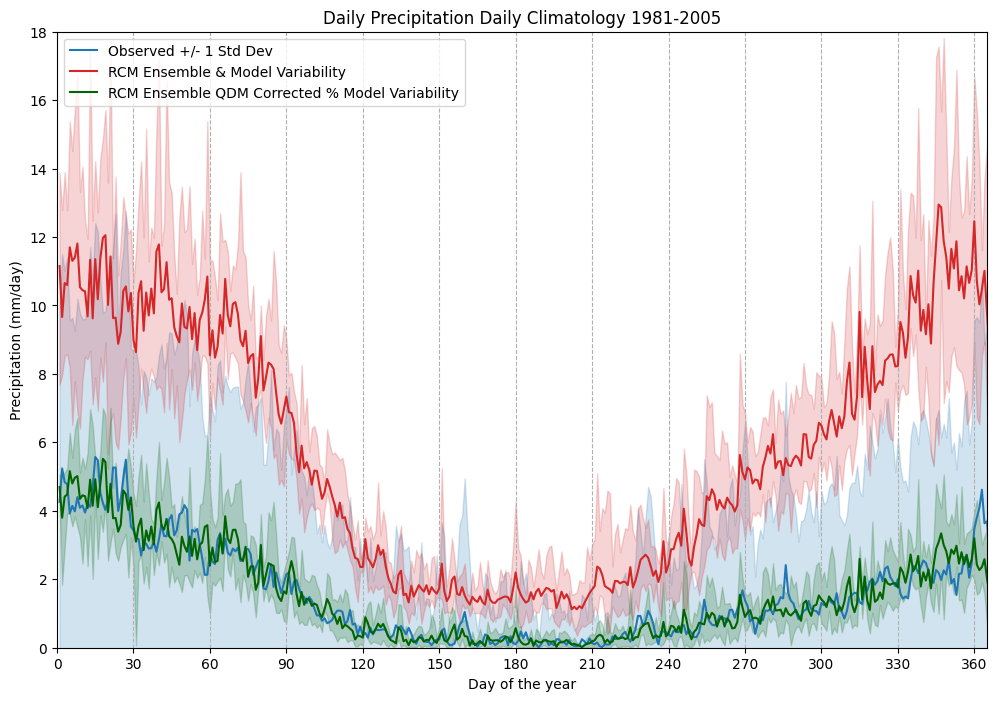

In [21]:
#Plotting historical climatology to see changes due to QDM Bias Correction

# PLOT PROPERTIES
title      = "Daily Precipitation Daily Climatology 1981-2005"
ylabel     = "Precipitation (mm/day)"
ylims      = [0,18]
label_hist = "Observed +/- 1 Std Dev"
label_raw  = "RCM Ensemble & Model Variability"
label_qdm  = "RCM Ensemble QDM Corrected % Model Variability"


#------------------------------------------------------------
fig,ax = plt.subplots(figsize=(12,8))
days=np.arange(1,367)
clim_hist_obs.plot(ax=ax,label=label_hist,color="tab:blue")
ax.plot(days,ens_hist_raw[0],label=label_raw,color="tab:red")
ax.plot(days,ens_hist_qdm[0],label=label_qdm,color="darkgreen")


# Fill with ensemble max and mean (1-sigma for observations)
ax.fill_between(clim_hist_obs.dayofyear,
                clim_hist_obs-clim_hist_obs_std,
                clim_hist_obs+clim_hist_obs_std,
                alpha=0.2,color="tab:blue")

ax.fill_between(days,
                ens_hist_raw[1],
                ens_hist_raw[2],
                alpha=0.2,color="tab:red")

ax.fill_between(days,
                ens_hist_qdm[1],
                ens_hist_qdm[2],
                alpha=0.2,color="darkgreen")


ax.set_title(title)
ax.set_ylabel(ylabel)
ax.set_xlabel("Day of the year")
ax.set_ylim(ylims)
ax.set_xlim(0,365)

ax.set_xticks(np.arange(0, 365, 30))

ax.legend(loc="upper left")
ax.grid(True, which='major', axis='x', linestyle='--', alpha=1)

plt.show()

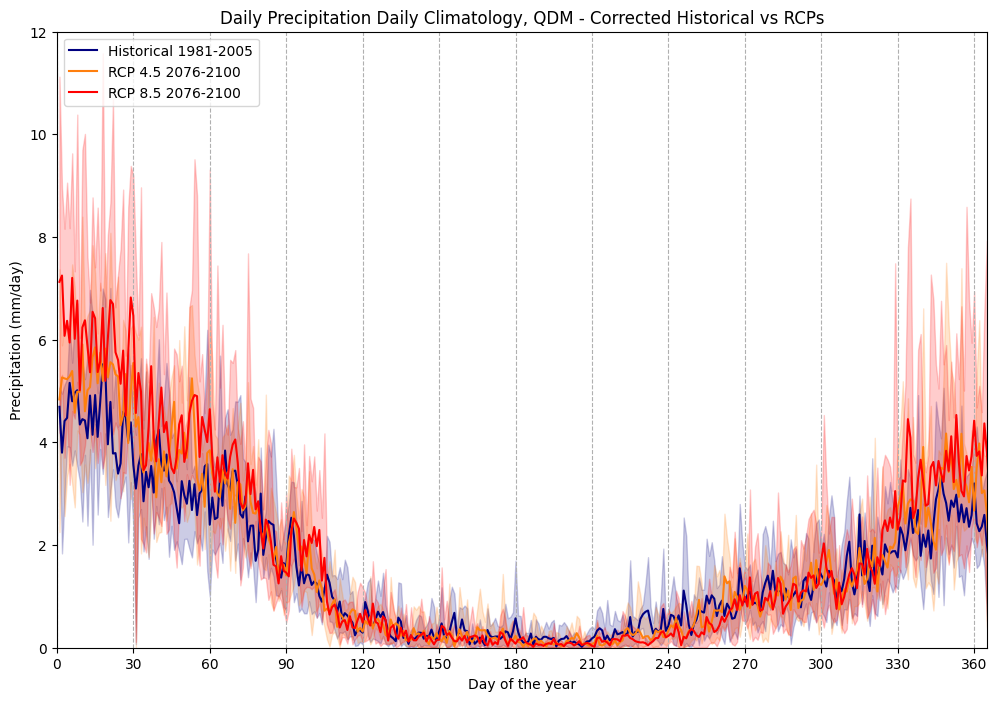

In [26]:
#Plotting historical vs future scenarios (QDM Corrected)

# PLOT PROPERTIES
title      = "Daily Precipitation Daily Climatology, QDM - Corrected Historical vs RCPs"
ylabel     = "Precipitation (mm/day)"
ylims      = [0,12]
label_hist = "Historical 1981-2005"
label_rcp45  = "RCP 4.5 2076-2100"
label_rcp85  = "RCP 8.5 2076-2100"


#------------------------------------------------------------
fig,ax = plt.subplots(figsize=(12,8))
days=np.arange(1,367)

ax.plot(days,ens_hist_qdm[0],label=label_hist,color="navy")
ax.plot(days,ens_rcp45_qdm[0],label=label_rcp45,color="tab:orange")
ax.plot(days,ens_rcp85_qdm[0],label=label_rcp85,color="red")


# Fill with ensemble max and mean 

ax.fill_between(days,
                ens_hist_qdm[1],
                ens_hist_qdm[2],
                alpha=0.2,color="navy")

ax.fill_between(days,
                ens_rcp45_qdm[1],
                ens_rcp45_qdm[2],
                alpha=0.2,color="tab:orange")

ax.fill_between(days,
                ens_rcp85_qdm[1],
                ens_rcp85_qdm[2],
                alpha=0.2,color="red")


ax.set_title(title)
ax.set_ylabel(ylabel)
ax.set_xlabel("Day of the year")
ax.set_ylim(ylims)
ax.set_xlim(0,365)

ax.set_xticks(np.arange(0, 365, 30))

ax.legend(loc="upper left")
ax.grid(True, which='major', axis='x', linestyle='--', alpha=1)


Export all qdm corrected datasets to netcdf

In [27]:
save_path = "data/CaseStudy/data/climate_data/RCM/bias_corr"

for rcm in model_list:
    hist_ds  = hist_data_qdm_dict[rcm]
    rcp45_ds = rcp45_data_qdm_dict[rcm]
    rcp85_ds = rcp85_data_qdm_dict[rcm]
    
    os.makedirs(f"{save_path}/historical/{rcm}", exist_ok=True)
    os.makedirs(f"{save_path}/rcp45/{rcm}", exist_ok=True)
    os.makedirs(f"{save_path}/rcp85/{rcm}", exist_ok=True)
    
    hist_ds.to_netcdf(f"{save_path}/historical/{rcm}/{rcm}_{variable}_historical_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_historical_bias_corr.nc")
    rcp45_ds.to_netcdf(f"{save_path}/rcp45/{rcm}/{rcm}_{variable}_rcp45_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_rcp45_bias_corr.nc")
    rcp85_ds.to_netcdf(f"{save_path}/rcp85/{rcm}/{rcm}_{variable}_rcp85_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_rcp85_bias_corr.nc")
    

Exported SAM_44_RCA4_EC_EARTH_pr_historical_bias_corr.nc
Exported SAM_44_RCA4_EC_EARTH_pr_rcp45_bias_corr.nc
Exported SAM_44_RCA4_EC_EARTH_pr_rcp85_bias_corr.nc
Exported SAM_44_RCA4_GFDL_pr_historical_bias_corr.nc
Exported SAM_44_RCA4_GFDL_pr_rcp45_bias_corr.nc
Exported SAM_44_RCA4_GFDL_pr_rcp85_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_pr_historical_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_pr_rcp45_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_pr_rcp85_bias_corr.nc
Exported SAM_44_RCA4_IPSL_pr_historical_bias_corr.nc
Exported SAM_44_RCA4_IPSL_pr_rcp45_bias_corr.nc
Exported SAM_44_RCA4_IPSL_pr_rcp85_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_pr_historical_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_pr_rcp45_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_pr_rcp85_bias_corr.nc


Export all qdm corrected datasets to netcdf

In [ ]:
save_path = "data/CaseStudy/data/climate_data/RCM/bias_corr"

for rcm in model_list:
    hist_ds  = hist_data_qdm_dict[rcm]
    rcp45_ds = rcp45_data_qdm_dict[rcm]
    rcp85_ds = rcp85_data_qdm_dict[rcm]
    
    os.makedirs(f"{save_path}/historical/{rcm}", exist_ok=True)
    os.makedirs(f"{save_path}/rcp45/{rcm}", exist_ok=True)
    os.makedirs(f"{save_path}/rcp85/{rcm}", exist_ok=True)
    
    hist_ds.to_netcdf(f"{save_path}/historical/{rcm}/{rcm}_{variable}_historical_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_historical_bias_corr.nc")
    rcp45_ds.to_netcdf(f"{save_path}/rcp45/{rcm}/{rcm}_{variable}_rcp45_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_rcp45_bias_corr.nc")
    rcp85_ds.to_netcdf(f"{save_path}/rcp85/{rcm}/{rcm}_{variable}_rcp85_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_rcp85_bias_corr.nc")
    

Exported SAM_44_RCA4_EC_EARTH_pr_historical_bias_corr.nc
Exported SAM_44_RCA4_EC_EARTH_pr_rcp45_bias_corr.nc
Exported SAM_44_RCA4_EC_EARTH_pr_rcp85_bias_corr.nc
Exported SAM_44_RCA4_GFDL_pr_historical_bias_corr.nc
Exported SAM_44_RCA4_GFDL_pr_rcp45_bias_corr.nc
Exported SAM_44_RCA4_GFDL_pr_rcp85_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_pr_historical_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_pr_rcp45_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_pr_rcp85_bias_corr.nc
Exported SAM_44_RCA4_IPSL_pr_historical_bias_corr.nc
Exported SAM_44_RCA4_IPSL_pr_rcp45_bias_corr.nc
Exported SAM_44_RCA4_IPSL_pr_rcp85_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_pr_historical_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_pr_rcp45_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_pr_rcp85_bias_corr.nc


## Bias correction for Maximum Temperature <br>
<hr>

In [60]:
# Paths and var
local_data_path = "data/CaseStudy/data/climate_data/local"
tables_path     = "tables/tmp"
stations_xslx   = "data/CaseStudy/data/climate_data/local/tables/katari_pcp_stations.xlsx"
variable = "tasmax"

In [61]:
# Reading local and storing into dictionary of Data Arrays
tmp_obs_dict = {} # Initialize dictionary
for station in os.listdir(f"{local_data_path}/{tables_path}"):
    file_path = f"{local_data_path}/{tables_path}/{station}"
    da = csv_to_dataarray(file_path,"tmax")
    key = station[:-4]
    pcp_obs_dict[key] = da

stations_table = pd.read_excel(stations_xslx)

stations_table

,NAME,LAT,LONG,ELEVATION
0,Achocalla,-16.580000,-68.160000,3764
1,Alto_Achachicala,-16.347222,-68.084722,4383
2,Batallas,-16.416667,-68.483333,3825
3,Belen,-16.020000,-68.700000,3833
4,Calamarca,-16.900000,-68.116667,3954
5,Caquiaviri,-17.020000,-68.610000,3951
6,Chirapaca,-16.299733,-68.497874,3870
7,Chuñavi_Alto,-16.316667,-68.333333,4000
8,Collana,-16.900000,-68.280000,3911
9,Coniri,-16.650000,-68.300000,3310


In [62]:
# Generating Bias Corrected data
time_start = "1981-01-01" # Time range for observed data used to downscaled (must match model data)
time_end   = "2005-12-31"

# Storage lists for historical data
station_ids = []
lats = []
lons = []
observed_data = []


# Read historical observed data once (CSV) and store as NETCDF
for index,row in stations_table.iterrows():
    # Read observed data for each station
    name = row["NAME"]
    lat  = row["LAT"]
    lon  = row["LONG"]
    da_obs = pcp_obs_dict[name]
    da_obs.attrs["units"] = "deg"
    observed_data.append(da_obs)
    station_ids.append(name)
    lats.append(lat)
    lons.append(lon)
    
time = observed_data[0]["time"]
observed_array = xr.DataArray(
    data=np.stack([c.values for c in observed_data]),
    dims=["station", "time"],
    coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
    name=f"{variable}"
)

obs_ds = observed_array.to_dataset() #  --> This is useful to save the data as NETCDF if needed
obs_ds.time.encoding["calendar"] = "standard"

# Read model data and apply bias correction
hist_data_qdm_dict = {} # Dictionary: for each RCM, a netcdf file with corrected data per station
rcp45_data_qdm_dict = {}
rcp85_data_qdm_dict = {}

# For raw data
hist_data_raw_dict = {}
rcp45_data_raw_dict = {}
rcp85_data_raw_dict = {}

obs_da = obs_ds[variable].sel(time=slice(time_start,time_end))    

for rcm in model_list:
    
    path_to_nc_hist = f"{rcm_data_path}/historical/{rcm}/{rcm}_{variable}_historical.nc"
    path_to_nc_rcp45 = f"{rcm_data_path}/rcp45/{rcm}/{rcm}_{variable}_rcp45.nc"
    path_to_nc_rcp85 = f"{rcm_data_path}/rcp85/{rcm}/{rcm}_{variable}_rcp85.nc"
    
    # Lists to store arrays
    raw_data = []
    corrected_data = []
    raw_data_rcp45 = []
    corrected_data_rcp45 = []
    raw_data_rcp85 = []
    corrected_data_rcp85 = []
    
    for index,row in stations_table.iterrows():
        # Read observed data for each station
        name = row["NAME"]
        lat  = row["LAT"]
        lon  = row["LONG"]

        stat_da = obs_da.sel(station = name) # Reading historical data from station
        stat_da.attrs["units"] = "mm/day"
        stat_da = stat_da.drop_vars(["lat","lon","station"])
        
        # Historical training and correction
        ds_mod_hist = xr.open_dataset(path_to_nc_hist)                        
        da_mod_hist = extract_model_point(ds_mod_hist,lat,lon,variable)-273.15 # Applying conversion to mm/day
        
        da_mod_hist = da_mod_hist.drop_vars(["lat","lon"])
         
        if da_mod_hist.time.encoding['calendar'] != 'standard': # Leap day Correction
            da_mod_hist_fill_data = float(da_mod_hist.mean().values)
            da_mod_hist = da_mod_hist.convert_calendar("standard",missing=da_mod_hist_fill_data,align_on="date")
            
        da_mod_hist['time'] = da_mod_hist['time'].dt.floor('D')
        da_mod_hist.attrs["units"] = "mm/day"

        qdm = qdm_train(stat_da, da_mod_hist,kind="+",time="time")
        da_mod_qdm = qdm.adjust(da_mod_hist)
        corrected_data.append(da_mod_qdm)
        raw_data.append(da_mod_hist)

        
        # Future correction rcp 45
        ds_mod_rcp45 = xr.open_dataset(path_to_nc_rcp45)
        da_mod_rcp45 = extract_model_point(ds_mod_rcp45,lat,lon,variable)-273.15
        da_mod_rcp45 = da_mod_rcp45.drop_vars(["lat","lon"]) 
        
        if da_mod_rcp45.time.encoding['calendar'] != 'standard': # Leap day Correction
            da_mod_rcp45_fill_data = float(da_mod_rcp45.mean().values)
            da_mod_rcp45 = da_mod_rcp45.convert_calendar("standard",missing=da_mod_rcp45_fill_data,align_on="date")
        
        da_mod_rcp45['time'] = da_mod_rcp45['time'].dt.floor('D')
        da_mod_rcp45.attrs["units"] = "mm/day"
        da_mod_qdm = qdm.adjust(da_mod_rcp45)
        corrected_data_rcp45.append(da_mod_qdm)
        raw_data_rcp45.append(da_mod_rcp45)
        
        # Future correction rcp 85
        ds_mod_rcp85 = xr.open_dataset(path_to_nc_rcp85)
        da_mod_rcp85 = extract_model_point(ds_mod_rcp85,lat,lon,variable)-273.15
        da_mod_rcp85 = da_mod_rcp85.drop_vars(["lat","lon"]) 

        if da_mod_rcp85.time.encoding['calendar'] != 'standard': # Leap day Correction
            da_mod_rcp85_fill_data = float(da_mod_rcp85.mean().values)
            da_mod_rcp85 = da_mod_rcp85.convert_calendar("standard",missing=da_mod_rcp85_fill_data,align_on="date")

        da_mod_rcp85['time'] = da_mod_rcp85['time'].dt.floor('D')
        da_mod_rcp85.attrs["units"] = "mm/day"
        da_mod_qdm = qdm.adjust(da_mod_rcp85)
        corrected_data_rcp85.append(da_mod_qdm)
        raw_data_rcp85.append(da_mod_rcp85)
    
    # Creating data_arrays and datasets for corrected data and raw data
    
    time = corrected_data[0]["time"] # Historical corrected
    corrected_array = xr.DataArray(
        data=np.stack([c.values for c in corrected_data]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")

    time = corrected_data_rcp45[0]["time"] # RCP 45 corrected
    corrected_data_rcp45_array = xr.DataArray(
        data=np.stack([c.values for c in corrected_data_rcp45]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    time = corrected_data_rcp85[0]["time"] # RCP 85 corrected
    corrected_data_rcp85_array = xr.DataArray(
        data=np.stack([c.values for c in corrected_data_rcp85]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    time = raw_data[0]["time"] # Historical corrected
    raw_array = xr.DataArray(
        data=np.stack([c.values for c in raw_data]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")

    time = raw_data_rcp45[0]["time"] # RCP 45 corrected
    raw_data_rcp45_array = xr.DataArray(
        data=np.stack([c.values for c in raw_data_rcp45]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    time = raw_data_rcp85[0]["time"] # RCP 85 corrected
    raw_data_rcp85_array = xr.DataArray(
        data=np.stack([c.values for c in raw_data_rcp85]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    
    hist_ds = corrected_array.to_dataset()
    raw_hist_ds = raw_array.to_dataset()
    rcp45_ds = corrected_data_rcp45_array.to_dataset()
    rcp85_ds = corrected_data_rcp85_array.to_dataset()
    raw_rcp45_ds = raw_data_rcp45_array.to_dataset()
    raw_rcp85_ds = raw_data_rcp85_array.to_dataset()
    
    # Storing in dictionaries of corrected data
    
    hist_data_qdm_dict[rcm]  = hist_ds
    rcp45_data_qdm_dict[rcm] = rcp45_ds
    rcp85_data_qdm_dict[rcm] = rcp85_ds
    
    hist_data_raw_dict[rcm] = raw_hist_ds
    rcp45_data_raw_dict[rcm] = raw_rcp45_ds
    rcp85_data_raw_dict[rcm] = raw_rcp85_ds
    print(f"Bias correction performed for model {rcm}") 

Bias correction performed for model SAM_44_RCA4_EC_EARTH
Bias correction performed for model SAM_44_RCA4_GFDL
Bias correction performed for model SAM_44_RCA4_HadGEM2
Bias correction performed for model SAM_44_RCA4_IPSL
Bias correction performed for model SAM_44_RCA4_MIROC5


Generating ensemble and plotting to show differences between Historical, Raw RCM and Bias corrected

In [63]:
# Getting climatologies - Aggregation per station
clim_hist_raw={}
clim_hist_qdm={}
clim_rcp45_raw={}
clim_rcp45_qdm={}
clim_rcp85_raw={}
clim_rcp85_qdm={}

clim_hist_obs=obs_da.groupby('time.dayofyear').mean(dim=["station","time"]).compute() # If working with gridded data instead of per station, change to lat and lon
clim_hist_obs_std=obs_da.groupby('time.dayofyear').std(dim=["station","time"]).compute()

for rcm in model_list:
    clim_hist_raw[rcm]=hist_data_raw_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    clim_hist_qdm[rcm]=hist_data_qdm_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    
    clim_rcp45_raw[rcm]=rcp45_data_raw_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    clim_rcp45_qdm[rcm]=rcp45_data_qdm_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    
    clim_rcp85_raw[rcm]=rcp85_data_raw_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    clim_rcp85_qdm[rcm]=rcp85_data_qdm_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    
# Getting ensembles among models
ens_hist_raw=ensemble_clim(clim_hist_raw)
ens_hist_qdm=ensemble_clim(clim_hist_qdm)
ens_rcp45_raw=ensemble_clim(clim_rcp45_raw)
ens_rcp45_qdm=ensemble_clim(clim_rcp45_qdm)
ens_rcp85_raw=ensemble_clim(clim_rcp85_raw)
ens_rcp85_qdm=ensemble_clim(clim_rcp85_qdm)

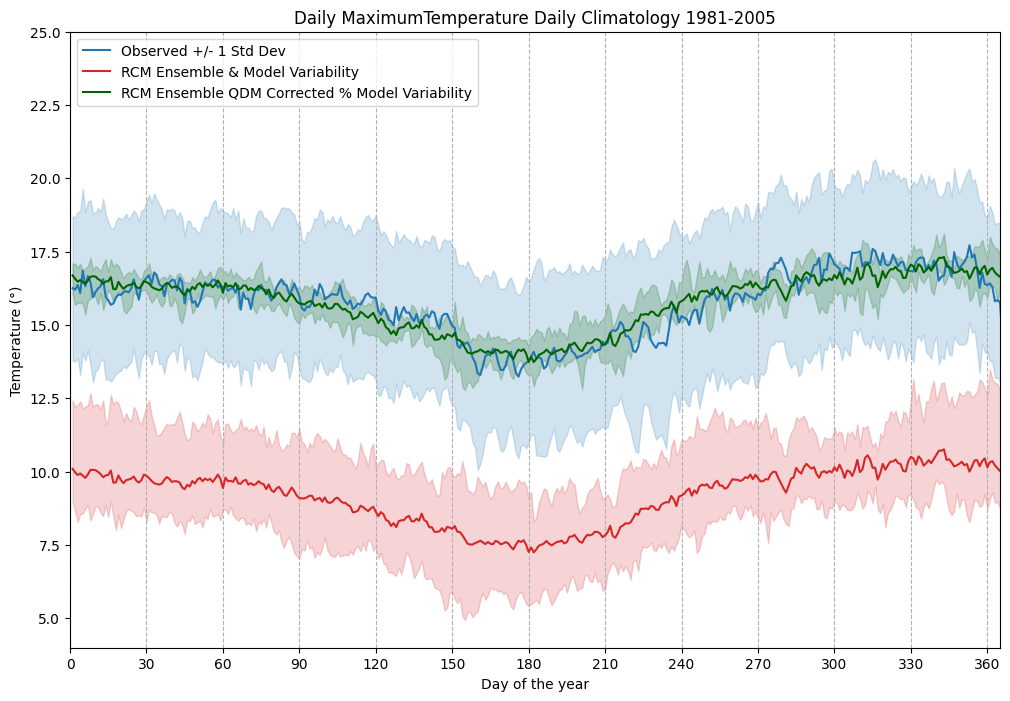

In [64]:
#Plotting historical climatology to see changes due to QDM Bias Correction

# PLOT PROPERTIES
title      = "Daily MaximumTemperature Daily Climatology 1981-2005"
ylabel     = "Temperature (°)"
ylims      = [4,25]
label_hist = "Observed +/- 1 Std Dev"
label_raw  = "RCM Ensemble & Model Variability"
label_qdm  = "RCM Ensemble QDM Corrected % Model Variability"


#------------------------------------------------------------
fig,ax = plt.subplots(figsize=(12,8))
days=np.arange(1,367)
clim_hist_obs.plot(ax=ax,label=label_hist,color="tab:blue")
ax.plot(days,ens_hist_raw[0],label=label_raw,color="tab:red")
ax.plot(days,ens_hist_qdm[0],label=label_qdm,color="darkgreen")


# Fill with ensemble max and mean (1-sigma for observations)
ax.fill_between(clim_hist_obs.dayofyear,
                clim_hist_obs-clim_hist_obs_std,
                clim_hist_obs+clim_hist_obs_std,
                alpha=0.2,color="tab:blue")

ax.fill_between(days,
                ens_hist_raw[1],
                ens_hist_raw[2],
                alpha=0.2,color="tab:red")

ax.fill_between(days,
                ens_hist_qdm[1],
                ens_hist_qdm[2],
                alpha=0.2,color="darkgreen")


ax.set_title(title)
ax.set_ylabel(ylabel)
ax.set_xlabel("Day of the year")
ax.set_ylim(ylims)
ax.set_xlim(0,365)

ax.set_xticks(np.arange(0, 365, 30))

ax.legend(loc="upper left")
ax.grid(True, which='major', axis='x', linestyle='--', alpha=1)

plt.show()

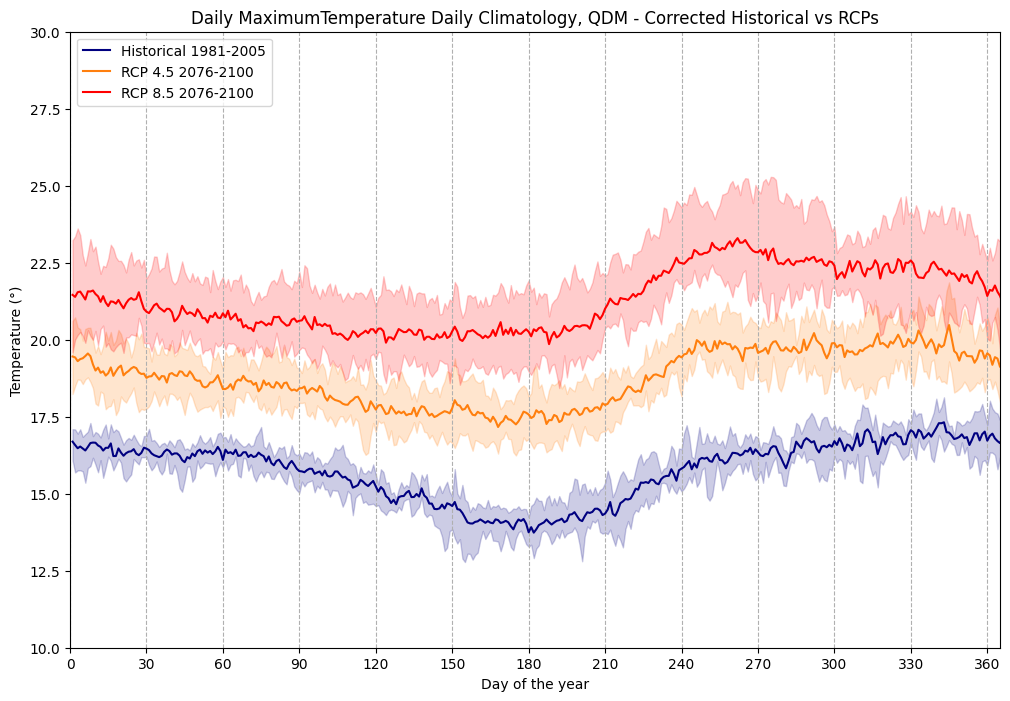

In [65]:
#Plotting historical vs future scenarios (QDM Corrected)

# PLOT PROPERTIES
title      = "Daily MaximumTemperature Daily Climatology, QDM - Corrected Historical vs RCPs"
ylabel     = "Temperature (°)"
ylims      = [10,30]
label_hist = "Historical 1981-2005"
label_rcp45  = "RCP 4.5 2076-2100"
label_rcp85  = "RCP 8.5 2076-2100"


#------------------------------------------------------------
fig,ax = plt.subplots(figsize=(12,8))
days=np.arange(1,367)

ax.plot(days,ens_hist_qdm[0],label=label_hist,color="navy")
ax.plot(days,ens_rcp45_qdm[0],label=label_rcp45,color="tab:orange")
ax.plot(days,ens_rcp85_qdm[0],label=label_rcp85,color="red")


# Fill with ensemble max and mean 

ax.fill_between(days,
                ens_hist_qdm[1],
                ens_hist_qdm[2],
                alpha=0.2,color="navy")

ax.fill_between(days,
                ens_rcp45_qdm[1],
                ens_rcp45_qdm[2],
                alpha=0.2,color="tab:orange")

ax.fill_between(days,
                ens_rcp85_qdm[1],
                ens_rcp85_qdm[2],
                alpha=0.2,color="red")


ax.set_title(title)
ax.set_ylabel(ylabel)
ax.set_xlabel("Day of the year")
ax.set_ylim(ylims)
ax.set_xlim(0,365)

ax.set_xticks(np.arange(0, 365, 30))

ax.legend(loc="upper left")
ax.grid(True, which='major', axis='x', linestyle='--', alpha=1)

Export all qdm corrected datasets to netcdf

In [66]:
save_path = "data/CaseStudy/data/climate_data/RCM/bias_corr"

for rcm in model_list:
    hist_ds  = hist_data_qdm_dict[rcm]
    rcp45_ds = rcp45_data_qdm_dict[rcm]
    rcp85_ds = rcp85_data_qdm_dict[rcm]
    
    os.makedirs(f"{save_path}/historical/{rcm}", exist_ok=True)
    os.makedirs(f"{save_path}/rcp45/{rcm}", exist_ok=True)
    os.makedirs(f"{save_path}/rcp85/{rcm}", exist_ok=True)
    
    hist_ds.to_netcdf(f"{save_path}/historical/{rcm}/{rcm}_{variable}_historical_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_historical_bias_corr.nc")
    rcp45_ds.to_netcdf(f"{save_path}/rcp45/{rcm}/{rcm}_{variable}_rcp45_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_rcp45_bias_corr.nc")
    rcp85_ds.to_netcdf(f"{save_path}/rcp85/{rcm}/{rcm}_{variable}_rcp85_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_rcp85_bias_corr.nc")
    

Exported SAM_44_RCA4_EC_EARTH_tasmax_historical_bias_corr.nc
Exported SAM_44_RCA4_EC_EARTH_tasmax_rcp45_bias_corr.nc
Exported SAM_44_RCA4_EC_EARTH_tasmax_rcp85_bias_corr.nc
Exported SAM_44_RCA4_GFDL_tasmax_historical_bias_corr.nc
Exported SAM_44_RCA4_GFDL_tasmax_rcp45_bias_corr.nc
Exported SAM_44_RCA4_GFDL_tasmax_rcp85_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_tasmax_historical_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_tasmax_rcp45_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_tasmax_rcp85_bias_corr.nc
Exported SAM_44_RCA4_IPSL_tasmax_historical_bias_corr.nc
Exported SAM_44_RCA4_IPSL_tasmax_rcp45_bias_corr.nc
Exported SAM_44_RCA4_IPSL_tasmax_rcp85_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_tasmax_historical_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_tasmax_rcp45_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_tasmax_rcp85_bias_corr.nc


## Bias correction for Minimum Temperature <br>
<hr>

In [44]:
# Paths and var
local_data_path = "data/CaseStudy/data/climate_data/local"
tables_path     = "tables/tmp"
stations_xslx   = "data/CaseStudy/data/climate_data/local/tables/katari_pcp_stations.xlsx"
variable = "tasmin"

In [45]:
# Reading local and storing into dictionary of Data Arrays
tmp_obs_dict = {} # Initialize dictionary
for station in os.listdir(f"{local_data_path}/{tables_path}"):
    file_path = f"{local_data_path}/{tables_path}/{station}"
    da = csv_to_dataarray(file_path,"tmin")
    key = station[:-4]
    pcp_obs_dict[key] = da

stations_table = pd.read_excel(stations_xslx)

stations_table

,NAME,LAT,LONG,ELEVATION
0,Achocalla,-16.580000,-68.160000,3764
1,Alto_Achachicala,-16.347222,-68.084722,4383
2,Batallas,-16.416667,-68.483333,3825
3,Belen,-16.020000,-68.700000,3833
4,Calamarca,-16.900000,-68.116667,3954
5,Caquiaviri,-17.020000,-68.610000,3951
6,Chirapaca,-16.299733,-68.497874,3870
7,Chuñavi_Alto,-16.316667,-68.333333,4000
8,Collana,-16.900000,-68.280000,3911
9,Coniri,-16.650000,-68.300000,3310


In [51]:
# Generating Bias Corrected data
time_start = "1981-01-01" # Time range for observed data used to downscaled (must match model data)
time_end   = "2005-12-31"

# Storage lists for historical data
station_ids = []
lats = []
lons = []
observed_data = []


# Read historical observed data once (CSV) and store as NETCDF
for index,row in stations_table.iterrows():
    # Read observed data for each station
    name = row["NAME"]
    lat  = row["LAT"]
    lon  = row["LONG"]
    da_obs = pcp_obs_dict[name]
    da_obs.attrs["units"] = "deg"
    observed_data.append(da_obs)
    station_ids.append(name)
    lats.append(lat)
    lons.append(lon)
    
time = observed_data[0]["time"]
observed_array = xr.DataArray(
    data=np.stack([c.values for c in observed_data]),
    dims=["station", "time"],
    coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
    name=f"{variable}"
)

obs_ds = observed_array.to_dataset() #  --> This is useful to save the data as NETCDF if needed
obs_ds.time.encoding["calendar"] = "standard"

# Read model data and apply bias correction
hist_data_qdm_dict = {} # Dictionary: for each RCM, a netcdf file with corrected data per station
rcp45_data_qdm_dict = {}
rcp85_data_qdm_dict = {}

# For raw data
hist_data_raw_dict = {}
rcp45_data_raw_dict = {}
rcp85_data_raw_dict = {}

obs_da = obs_ds[variable].sel(time=slice(time_start,time_end))    

for rcm in model_list:
    
    path_to_nc_hist = f"{rcm_data_path}/historical/{rcm}/{rcm}_{variable}_historical.nc"
    path_to_nc_rcp45 = f"{rcm_data_path}/rcp45/{rcm}/{rcm}_{variable}_rcp45.nc"
    path_to_nc_rcp85 = f"{rcm_data_path}/rcp85/{rcm}/{rcm}_{variable}_rcp85.nc"
    
    # Lists to store arrays
    raw_data = []
    corrected_data = []
    raw_data_rcp45 = []
    corrected_data_rcp45 = []
    raw_data_rcp85 = []
    corrected_data_rcp85 = []
    
    for index,row in stations_table.iterrows():
        # Read observed data for each station
        name = row["NAME"]
        lat  = row["LAT"]
        lon  = row["LONG"]

        stat_da = obs_da.sel(station = name) # Reading historical data from station
        stat_da.attrs["units"] = "mm/day"
        stat_da = stat_da.drop_vars(["lat","lon","station"])
        
        # Historical training and correction
        ds_mod_hist = xr.open_dataset(path_to_nc_hist)                        
        da_mod_hist = extract_model_point(ds_mod_hist,lat,lon,variable)-273.15 # Applying conversion to mm/day
        
        da_mod_hist = da_mod_hist.drop_vars(["lat","lon"])
         
        if da_mod_hist.time.encoding['calendar'] != 'standard': # Leap day Correction
            da_mod_hist_fill_data = float(da_mod_hist.mean().values)
            da_mod_hist = da_mod_hist.convert_calendar("standard",missing=da_mod_hist_fill_data,align_on="date")
            
        da_mod_hist['time'] = da_mod_hist['time'].dt.floor('D')
        da_mod_hist.attrs["units"] = "mm/day"

        qdm = qdm_train(stat_da, da_mod_hist,kind="+",time="time")
        da_mod_qdm = qdm.adjust(da_mod_hist)
        corrected_data.append(da_mod_qdm)
        raw_data.append(da_mod_hist)

        
        # Future correction rcp 45
        ds_mod_rcp45 = xr.open_dataset(path_to_nc_rcp45)
        da_mod_rcp45 = extract_model_point(ds_mod_rcp45,lat,lon,variable)-273.15
        da_mod_rcp45 = da_mod_rcp45.drop_vars(["lat","lon"]) 
        
        if da_mod_rcp45.time.encoding['calendar'] != 'standard': # Leap day Correction
            da_mod_rcp45_fill_data = float(da_mod_rcp45.mean().values)
            da_mod_rcp45 = da_mod_rcp45.convert_calendar("standard",missing=da_mod_rcp45_fill_data,align_on="date")
        
        da_mod_rcp45['time'] = da_mod_rcp45['time'].dt.floor('D')
        da_mod_rcp45.attrs["units"] = "mm/day"
        da_mod_qdm = qdm.adjust(da_mod_rcp45)
        corrected_data_rcp45.append(da_mod_qdm)
        raw_data_rcp45.append(da_mod_rcp45)
        
        # Future correction rcp 85
        ds_mod_rcp85 = xr.open_dataset(path_to_nc_rcp85)
        da_mod_rcp85 = extract_model_point(ds_mod_rcp85,lat,lon,variable)-273.15
        da_mod_rcp85 = da_mod_rcp85.drop_vars(["lat","lon"]) 

        if da_mod_rcp85.time.encoding['calendar'] != 'standard': # Leap day Correction
            da_mod_rcp85_fill_data = float(da_mod_rcp85.mean().values)
            da_mod_rcp85 = da_mod_rcp85.convert_calendar("standard",missing=da_mod_rcp85_fill_data,align_on="date")

        da_mod_rcp85['time'] = da_mod_rcp85['time'].dt.floor('D')
        da_mod_rcp85.attrs["units"] = "mm/day"
        da_mod_qdm = qdm.adjust(da_mod_rcp85)
        corrected_data_rcp85.append(da_mod_qdm)
        raw_data_rcp85.append(da_mod_rcp85)
    
    # Creating data_arrays and datasets for corrected data and raw data
    
    time = corrected_data[0]["time"] # Historical corrected
    corrected_array = xr.DataArray(
        data=np.stack([c.values for c in corrected_data]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")

    time = corrected_data_rcp45[0]["time"] # RCP 45 corrected
    corrected_data_rcp45_array = xr.DataArray(
        data=np.stack([c.values for c in corrected_data_rcp45]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    time = corrected_data_rcp85[0]["time"] # RCP 85 corrected
    corrected_data_rcp85_array = xr.DataArray(
        data=np.stack([c.values for c in corrected_data_rcp85]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    time = raw_data[0]["time"] # Historical corrected
    raw_array = xr.DataArray(
        data=np.stack([c.values for c in raw_data]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")

    time = raw_data_rcp45[0]["time"] # RCP 45 corrected
    raw_data_rcp45_array = xr.DataArray(
        data=np.stack([c.values for c in raw_data_rcp45]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    time = raw_data_rcp85[0]["time"] # RCP 85 corrected
    raw_data_rcp85_array = xr.DataArray(
        data=np.stack([c.values for c in raw_data_rcp85]),
        dims=["station", "time"],
        coords={"station": station_ids, "time": time, "lat": ("station", lats), "lon": ("station", lons)},
        name=f"{variable}")
    
    
    hist_ds = corrected_array.to_dataset()
    raw_hist_ds = raw_array.to_dataset()
    rcp45_ds = corrected_data_rcp45_array.to_dataset()
    rcp85_ds = corrected_data_rcp85_array.to_dataset()
    raw_rcp45_ds = raw_data_rcp45_array.to_dataset()
    raw_rcp85_ds = raw_data_rcp85_array.to_dataset()
    
    # Storing in dictionaries of corrected data
    
    hist_data_qdm_dict[rcm]  = hist_ds
    rcp45_data_qdm_dict[rcm] = rcp45_ds
    rcp85_data_qdm_dict[rcm] = rcp85_ds
    
    hist_data_raw_dict[rcm] = raw_hist_ds
    rcp45_data_raw_dict[rcm] = raw_rcp45_ds
    rcp85_data_raw_dict[rcm] = raw_rcp85_ds
    print(f"Bias correction performed for model {rcm}") 

Bias correction performed for model SAM_44_RCA4_EC_EARTH
Bias correction performed for model SAM_44_RCA4_GFDL
Bias correction performed for model SAM_44_RCA4_HadGEM2
Bias correction performed for model SAM_44_RCA4_IPSL
Bias correction performed for model SAM_44_RCA4_MIROC5


Generating ensemble and plotting to show differences between Historical, Raw RCM and Bias corrected

In [52]:
# Getting climatologies - Aggregation per station
clim_hist_raw={}
clim_hist_qdm={}
clim_rcp45_raw={}
clim_rcp45_qdm={}
clim_rcp85_raw={}
clim_rcp85_qdm={}

clim_hist_obs=obs_da.groupby('time.dayofyear').mean(dim=["station","time"]).compute() # If working with gridded data instead of per station, change to lat and lon
clim_hist_obs_std=obs_da.groupby('time.dayofyear').std(dim=["station","time"]).compute()

for rcm in model_list:
    clim_hist_raw[rcm]=hist_data_raw_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    clim_hist_qdm[rcm]=hist_data_qdm_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    
    clim_rcp45_raw[rcm]=rcp45_data_raw_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    clim_rcp45_qdm[rcm]=rcp45_data_qdm_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    
    clim_rcp85_raw[rcm]=rcp85_data_raw_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    clim_rcp85_qdm[rcm]=rcp85_data_qdm_dict[rcm][variable].groupby('time.dayofyear').mean(dim=["station","time"]).compute()
    
# Getting ensembles among models
ens_hist_raw=ensemble_clim(clim_hist_raw)
ens_hist_qdm=ensemble_clim(clim_hist_qdm)
ens_rcp45_raw=ensemble_clim(clim_rcp45_raw)
ens_rcp45_qdm=ensemble_clim(clim_rcp45_qdm)
ens_rcp85_raw=ensemble_clim(clim_rcp85_raw)
ens_rcp85_qdm=ensemble_clim(clim_rcp85_qdm)

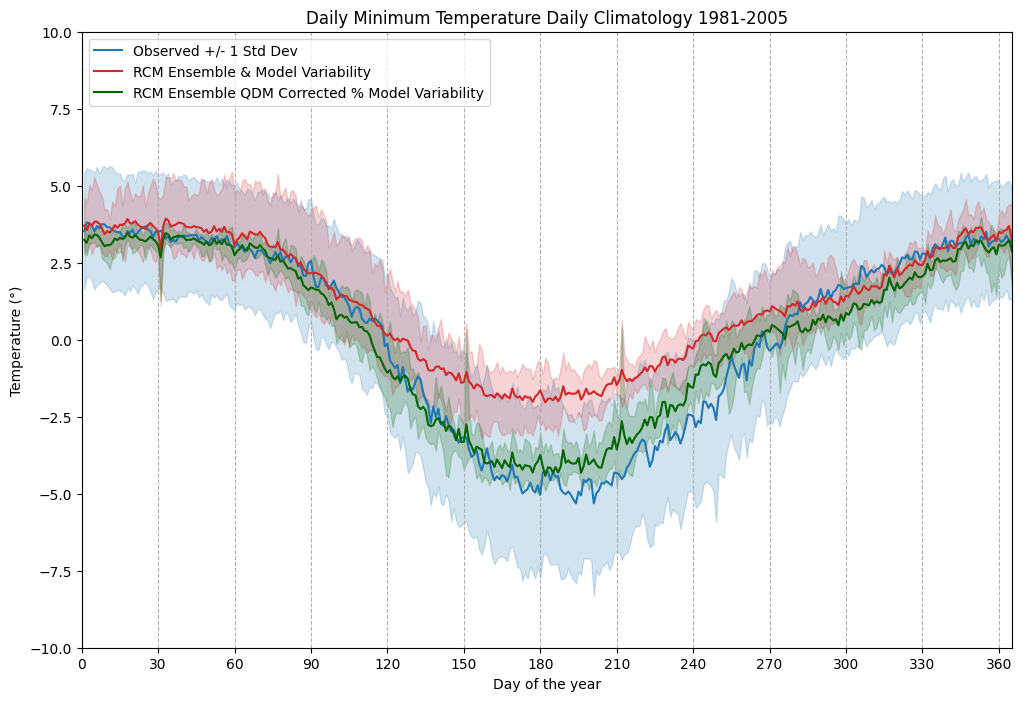

In [53]:
#Plotting historical climatology to see changes due to QDM Bias Correction

# PLOT PROPERTIES
title      = "Daily Minimum Temperature Daily Climatology 1981-2005"
ylabel     = "Temperature (°)"
ylims      = [-10,10]
label_hist = "Observed +/- 1 Std Dev"
label_raw  = "RCM Ensemble & Model Variability"
label_qdm  = "RCM Ensemble QDM Corrected % Model Variability"


#------------------------------------------------------------
fig,ax = plt.subplots(figsize=(12,8))
days=np.arange(1,367)
clim_hist_obs.plot(ax=ax,label=label_hist,color="tab:blue")
ax.plot(days,ens_hist_raw[0],label=label_raw,color="tab:red")
ax.plot(days,ens_hist_qdm[0],label=label_qdm,color="darkgreen")


# Fill with ensemble max and mean (1-sigma for observations)
ax.fill_between(clim_hist_obs.dayofyear,
                clim_hist_obs-clim_hist_obs_std,
                clim_hist_obs+clim_hist_obs_std,
                alpha=0.2,color="tab:blue")

ax.fill_between(days,
                ens_hist_raw[1],
                ens_hist_raw[2],
                alpha=0.2,color="tab:red")

ax.fill_between(days,
                ens_hist_qdm[1],
                ens_hist_qdm[2],
                alpha=0.2,color="darkgreen")


ax.set_title(title)
ax.set_ylabel(ylabel)
ax.set_xlabel("Day of the year")
ax.set_ylim(ylims)
ax.set_xlim(0,365)

ax.set_xticks(np.arange(0, 365, 30))

ax.legend(loc="upper left")
ax.grid(True, which='major', axis='x', linestyle='--', alpha=1)

plt.show()

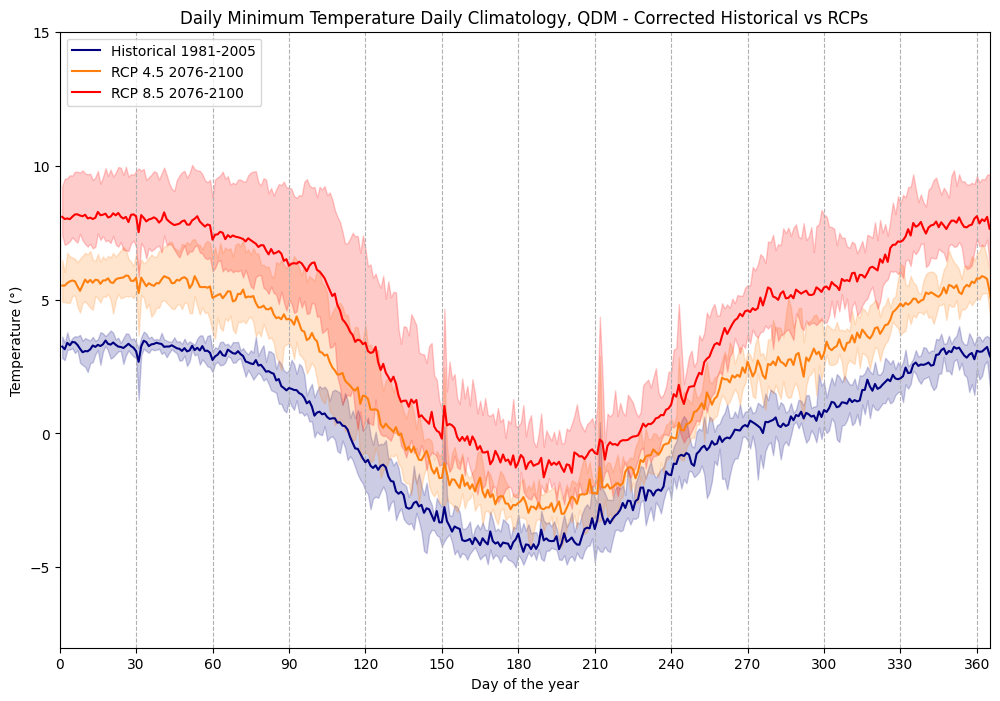

In [55]:
#Plotting historical vs future scenarios (QDM Corrected)

# PLOT PROPERTIES
title      = "Daily Minimum Temperature Daily Climatology, QDM - Corrected Historical vs RCPs"
ylabel     = "Temperature (°)"
ylims      = [-8,15]
label_hist = "Historical 1981-2005"
label_rcp45  = "RCP 4.5 2076-2100"
label_rcp85  = "RCP 8.5 2076-2100"


#------------------------------------------------------------
fig,ax = plt.subplots(figsize=(12,8))
days=np.arange(1,367)

ax.plot(days,ens_hist_qdm[0],label=label_hist,color="navy")
ax.plot(days,ens_rcp45_qdm[0],label=label_rcp45,color="tab:orange")
ax.plot(days,ens_rcp85_qdm[0],label=label_rcp85,color="red")


# Fill with ensemble max and mean 

ax.fill_between(days,
                ens_hist_qdm[1],
                ens_hist_qdm[2],
                alpha=0.2,color="navy")

ax.fill_between(days,
                ens_rcp45_qdm[1],
                ens_rcp45_qdm[2],
                alpha=0.2,color="tab:orange")

ax.fill_between(days,
                ens_rcp85_qdm[1],
                ens_rcp85_qdm[2],
                alpha=0.2,color="red")


ax.set_title(title)
ax.set_ylabel(ylabel)
ax.set_xlabel("Day of the year")
ax.set_ylim(ylims)
ax.set_xlim(0,365)

ax.set_xticks(np.arange(0, 365, 30))

ax.legend(loc="upper left")
ax.grid(True, which='major', axis='x', linestyle='--', alpha=1)

Export all qdm corrected datasets to netcdf

In [56]:
save_path = "data/CaseStudy/data/climate_data/RCM/bias_corr"

for rcm in model_list:
    hist_ds  = hist_data_qdm_dict[rcm]
    rcp45_ds = rcp45_data_qdm_dict[rcm]
    rcp85_ds = rcp85_data_qdm_dict[rcm]
    
    os.makedirs(f"{save_path}/historical/{rcm}", exist_ok=True)
    os.makedirs(f"{save_path}/rcp45/{rcm}", exist_ok=True)
    os.makedirs(f"{save_path}/rcp85/{rcm}", exist_ok=True)
    
    hist_ds.to_netcdf(f"{save_path}/historical/{rcm}/{rcm}_{variable}_historical_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_historical_bias_corr.nc")
    rcp45_ds.to_netcdf(f"{save_path}/rcp45/{rcm}/{rcm}_{variable}_rcp45_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_rcp45_bias_corr.nc")
    rcp85_ds.to_netcdf(f"{save_path}/rcp85/{rcm}/{rcm}_{variable}_rcp85_bias_corr.nc")
    print(f"Exported {rcm}_{variable}_rcp85_bias_corr.nc")
    

Exported SAM_44_RCA4_EC_EARTH_tasmin_historical_bias_corr.nc
Exported SAM_44_RCA4_EC_EARTH_tasmin_rcp45_bias_corr.nc
Exported SAM_44_RCA4_EC_EARTH_tasmin_rcp85_bias_corr.nc
Exported SAM_44_RCA4_GFDL_tasmin_historical_bias_corr.nc
Exported SAM_44_RCA4_GFDL_tasmin_rcp45_bias_corr.nc
Exported SAM_44_RCA4_GFDL_tasmin_rcp85_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_tasmin_historical_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_tasmin_rcp45_bias_corr.nc
Exported SAM_44_RCA4_HadGEM2_tasmin_rcp85_bias_corr.nc
Exported SAM_44_RCA4_IPSL_tasmin_historical_bias_corr.nc
Exported SAM_44_RCA4_IPSL_tasmin_rcp45_bias_corr.nc
Exported SAM_44_RCA4_IPSL_tasmin_rcp85_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_tasmin_historical_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_tasmin_rcp45_bias_corr.nc
Exported SAM_44_RCA4_MIROC5_tasmin_rcp85_bias_corr.nc
